In [2]:
# --- 全局中文字体配置（使用本地 NotoSansSC-Black.ttf） ---
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import seaborn as sns
from pathlib import Path

# 本地字体文件（放在 Notebook 同目录）
FONT_FILE = Path("NotoSansSC-Black.ttf")
if not FONT_FILE.exists():
    raise FileNotFoundError(f"请把 {FONT_FILE} 放到当前目录下")

# 注册并获取字体名称
fm.fontManager.addfont(str(FONT_FILE.resolve()))
FONT_NAME = fm.FontProperties(fname=str(FONT_FILE.resolve())).get_name()

# 设置全局字体（Matplotlib + Seaborn）
rcParams["font.family"] = [FONT_NAME]
rcParams["axes.unicode_minus"] = False
sns.set_theme(font=FONT_NAME, rc={"axes.unicode_minus": False})

print("✅ 中文字体启用：", FONT_NAME)


✅ 中文字体启用： Noto Sans SC


In [3]:
import numpy as np
import pandas as pd

np.random.seed(42)

num_employees = 1000
base_productivity = np.random.normal(loc=70, scale=10, size=num_employees)
true_causal_effect = 10

# 潜在结果
potential_outcome_0 = base_productivity
potential_outcome_1 = base_productivity + true_causal_effect

# 构造总体数据
population = pd.DataFrame({
    'employee_id': range(num_employees),
    'base_productivity': base_productivity,
    'Y0': potential_outcome_0,
    'Y1': potential_outcome_1
})

# 计算真实 ATE
true_ATE = (population['Y1'] - population['Y0']).mean()
print(f"The True Average Treatment Effect (ATE) is: {true_ATE:.2f}")

# 随机分配处理组
population['T'] = np.random.binomial(1, 0.5, size=num_employees)
population['Y_observed'] = np.where(population['T'] == 1, 
                                    population['Y1'], 
                                    population['Y0'])

# 估计 ATE
mean_treated = population.loc[population['T'] == 1, 'Y_observed'].mean()
mean_control = population.loc[population['T'] == 0, 'Y_observed'].mean()
estimated_ATE = mean_treated - mean_control

print("--- RCT Results ---")
print(f"Average outcome for Treated Group: {mean_treated:.2f}")
print(f"Average outcome for Control Group: {mean_control:.2f}")
print(f"Estimated ATE from RCT: {estimated_ATE:.2f}")


The True Average Treatment Effect (ATE) is: 10.00
--- RCT Results ---
Average outcome for Treated Group: 80.64
Average outcome for Control Group: 69.72
Estimated ATE from RCT: 10.92


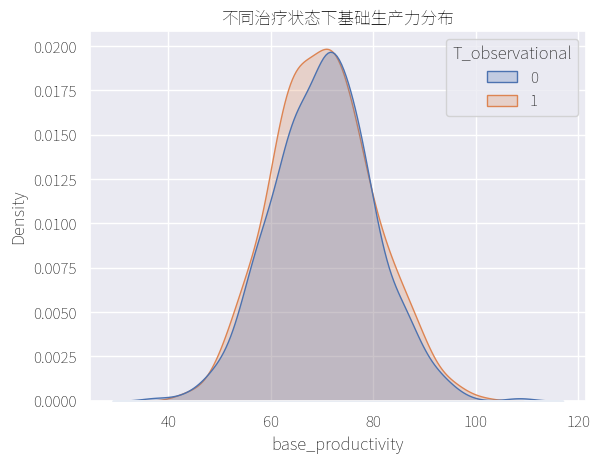

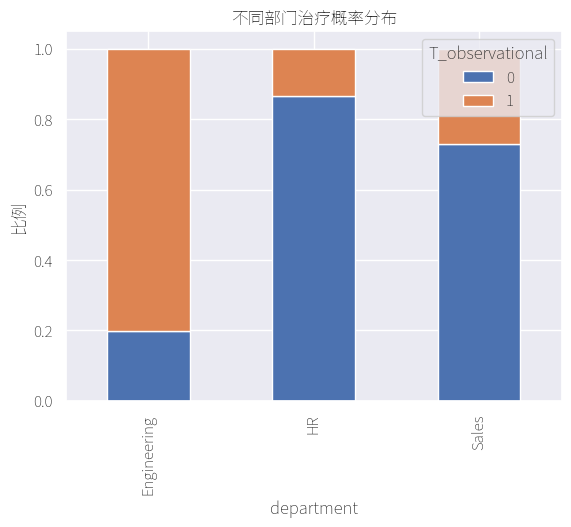

In [4]:

import seaborn as sns
import matplotlib.pyplot as plt

population['department'] = np.random.choice(['Sales', 'Engineering', 'HR'],
                                          size=num_employees, p=[0.4, 0.5, 0.1])
prob_treatment = np.where(population['department'] == 'Engineering', 0.8,
                          np.where(population['department'] == 'Sales', 0.3, 0.1))
population['T_observational'] = np.random.binomial(1, prob_treatment)

sns.kdeplot(data=population, x='base_productivity', hue='T_observational', fill=True)
plt.title('不同治疗状态下基础生产力分布')
plt.show()

pd.crosstab(population['department'], population['T_observational'],
            normalize='index').plot(kind='bar', stacked=True)
plt.title('不同部门治疗概率分布')
plt.ylabel('比例')
plt.show()


In [5]:

import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
np.random.seed(123)

n_firms = 1000
M = np.random.normal(0, 1, n_firms)
Z = np.random.binomial(1, 0.5, n_firms)
T_prob = 0.2 + 0.4 * Z + 0.3 * M + np.random.normal(0, 0.1, n_firms)
T = (T_prob > 0.5).astype(int)
true_effect = 15
Y = 100 + true_effect * T + 20 * M + np.random.normal(0, 5, n_firms)

data = pd.DataFrame({'Y': Y, 'T': T, 'Z': Z, 'M': M})
data['const'] = 1

ols_model = sm.OLS(data['Y'], data[['const', 'T']]).fit()
print(f"Biased OLS Estimate: {ols_model.params['T']:.2f}\n")

iv_model = IV2SLS(dependent=data['Y'],
                  exog=data['const'],
                  endog=data['T'],
                  instruments=data['Z']).fit(cov_type='robust')
print("--- IV (2SLS) Estimate ---")
print(iv_model)




Biased OLS Estimate: 39.71

--- IV (2SLS) Estimate ---
                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                      0.3171
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3164
No. Observations:                1000   F-statistic:                    17.860
Date:                Thu, Nov 27 2025   P-value (F-stat)                0.0000
Time:                        14:16:25   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          99.946     1.4110     70.835     0.0000      97.181      102.

--- Regression DiD Results ---
                            OLS Regression Results                            
Dep. Variable:             employment   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     34.36
Date:                Thu, 27 Nov 2025   Prob (F-statistic):           9.31e-20
Time:                        14:16:28   Log-Likelihood:                -1026.3
No. Observations:                 400   AIC:                             2061.
Df Residuals:                     396   BIC:                             2077.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

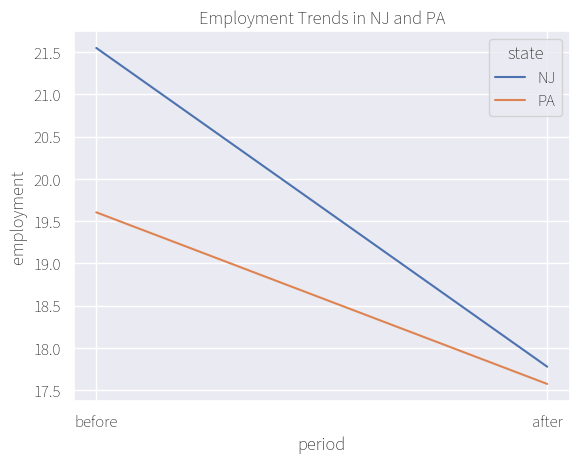

In [6]:

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(456)

n_stores = 200
stores = pd.DataFrame({
    'store_id': range(n_stores),
    'state': ['NJ'] * (n_stores // 2) + ['PA'] * (n_stores // 2)
})
df = pd.concat([stores, stores], ignore_index=True)
df['period'] = ['before'] * n_stores + ['after'] * n_stores
df['treat_group'] = (df['state'] == 'NJ').astype(int)
df['after_period'] = (df['period'] == 'after').astype(int)

common_trend = -2
treatment_effect = -1.5
base_employment = np.random.normal(20, 3, len(df))
state_effect = np.where(df['state'] == 'NJ', 1, 0)

df['employment'] = (base_employment + state_effect +
                    df['after_period'] * common_trend +
                    df['treat_group'] * df['after_period'] * treatment_effect +
                    np.random.normal(0, 1, len(df)))

did_model = smf.ols('employment ~ treat_group * after_period', data=df).fit()
print("--- Regression DiD Results ---")
print(did_model.summary())

sns.lineplot(data=df, x='period', y='employment', hue='state', errorbar=None)
plt.title('Employment Trends in NJ and PA')
plt.show()



In [7]:

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
np.random.seed(789)

n_students = 5000
exam_score = np.random.uniform(50, 100, n_students)
cutoff = 80
scholarship = (exam_score >= cutoff).astype(int)
treatment_effect = 0.25
gpa = (1.5 + 0.03 * (exam_score - cutoff) +
       treatment_effect * scholarship +
       np.random.normal(0, 0.2, n_students))

df = pd.DataFrame({'score': exam_score, 'scholarship': scholarship, 'gpa': gpa})
df['score_centered'] = df['score'] - cutoff

rdd_model = smf.ols('gpa ~ score_centered * scholarship', data=df).fit()
print(rdd_model.summary())

# 省略可视化代码

# ⚠️ 可能需要人工修复


                            OLS Regression Results                            
Dep. Variable:                    gpa   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 1.183e+04
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:16:31   Log-Likelihood:                 882.82
No. Observations:                5000   AIC:                            -1758.
Df Residuals:                    4996   BIC:                            -1732.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [8]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

np.random.seed(101)
n_workers = 2000
age = np.random.normal(40, 10, n_workers)
skill = np.random.normal(100, 15, n_workers)
prob_treat = 1 / (1 + np.exp(-( -10 + 0.1 * age + 0.05 * skill)))
treatment = np.random.binomial(1, prob_treat, n_workers)

true_effect = 5000
wage = 30000 + 100 * age + 200 * skill + true_effect * treatment + np.random.normal(0, 5000, n_workers)

df = pd.DataFrame({'age': age, 'skill': skill, 'treatment': treatment, 'wage': wage})

X = df[['age', 'skill']]
logit = LogisticRegression().fit(X, df['treatment'])
df['propensity_score'] = logit.predict_proba(X)[:, 1]

treated = df[df['treatment'] == 1]
control = df[df['treatment'] == 0]
nn = NearestNeighbors(n_neighbors=1).fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()]

att_estimate = treated['wage'].mean() - matched_control['wage'].mean()
print(f"PSM Estimated ATT: ${att_estimate:,.2f}")




PSM Estimated ATT: $4,775.89


In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from econml.dml import LinearDML
import matplotlib.pyplot as plt

np.random.seed(123)
n_firms = 2000
n_features = 20
true_effect = 5.0

X = np.random.normal(0, 1, size=(n_firms, n_features))
treatment_propensity = 0.5 * (X[:, 0] > 0) + 0.25 * (X[:, 1] > 0.5)
D = np.random.binomial(1, treatment_propensity)
y0 = 2 * X[:, 0] * X[:, 1] + np.sin(X[:, 2])
Y = y0 + true_effect * D

# Naive Lasso 回归
naive_model_data = np.hstack([D.reshape(-1, 1), X])
naive_model = LassoCV(cv=5).fit(naive_model_data, Y)
naive_estimate = naive_model.coef_
print(f"Naive Lasso Estimate (treatment coef): {naive_estimate[0]:.3f}\n")

# DML 估计
dml_estimator = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100),
    model_t=RandomForestRegressor(n_estimators=100),
    random_state=42
)
dml_estimator.fit(Y, T=D, X=X)

dml_estimate = dml_estimator.effect(X)
lower, upper = dml_estimator.effect_interval(X)

print(f"DML Estimated Causal Effect (avg): {np.mean(dml_estimate):.3f}")
print(f"95% Confidence Interval: [{np.mean(lower):.3f}, {np.mean(upper):.3f}]")


Naive Lasso Estimate (treatment coef): 4.780

DML Estimated Causal Effect (avg): 4.829
95% Confidence Interval: [4.296, 5.363]


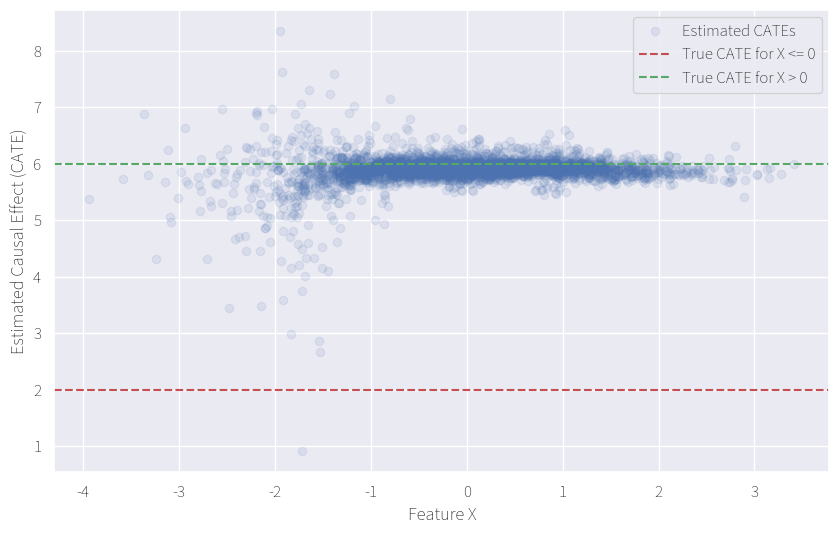

In [10]:

import numpy as np
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

np.random.seed(456)
n_firms = 4000
n_features = 20

X = np.random.normal(0, 1, size=(n_firms, n_features))
D = np.random.binomial(1, 0.5 * (X[:, 0] > 0))
true_cate = 2 + 4 * (X[:, 0] > 0)
y0 = 2 * X[:, 0] * X[:, 1] + np.sin(X[:, 2])
Y = y0 + true_cate * D

causal_forest = CausalForestDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    random_state=42
)
causal_forest.fit(Y, T=D, X=X)
estimated_cates = causal_forest.effect(X)

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], estimated_cates, alpha=0.1, label='Estimated CATEs')
plt.xlabel("Feature X")
plt.ylabel("Estimated Causal Effect (CATE)")
plt.axhline(y=2.0, color='r', linestyle='--', label='True CATE for X <= 0')
plt.axhline(y=6.0, color='g', linestyle='--', label='True CATE for X > 0')
plt.legend()
plt.show()

# ⚠️ 可能需要人工修复


  0%|          | 0/3 [00:00<?, ?it/s]

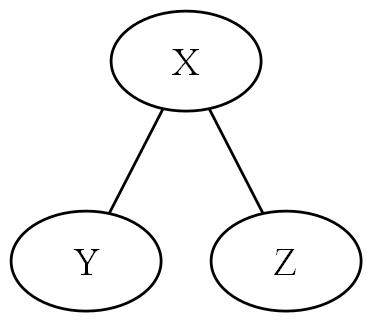

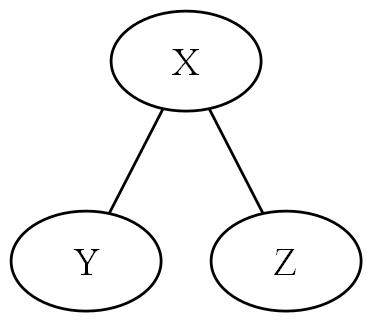

In [1]:
import numpy as np
import pandas as pd
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from IPython.display import Image, display

# 模拟数据
np.random.seed(678)
n_samples = 1000
Z = np.random.uniform(size=n_samples)
X = 2 * Z + np.random.normal(size=n_samples)
Y = 3 * X + np.random.normal(size=n_samples)

data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

# PC 算法
cg = pc(data.to_numpy(), alpha=0.05)

# 转换为 pydot 图，并加标签
p = GraphUtils.to_pydot(cg.G, labels=list(data.columns))

# 方法 1：保存为 PNG 文件
p.write_png('causal_graph.png')
display(Image(filename='causal_graph.png'))

# 方法 2：直接 Notebook 内联显示
display(Image(p.create_png()))


In [2]:
!pip install causal-learn -i https://pypi.tuna.tsinghua.edu.cn/simple


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
np.random.seed(42)
n_customers = 100000
# 特征：'loyalty_score' 与 'price_sensitivity'
loyalty_score = np.random.uniform(0, 1, n_customers)
price_sensitivity = np.random.uniform(0, 1, n_customers)
# 未发券下转化概率依赖客户忠诚度
prob_convert_control = 0.05 + 0.4 * loyalty_score**2
# 提升效应依赖价格敏感度
true_uplift = 0.5 * price_sensitivity**2
# 发券后的转化概率
prob_convert_treatment = np.clip(prob_convert_control + true_uplift, 0, 1)
# 模拟随机对照实验
treatment_group = np.random.binomial(1, 0.5, size=n_customers)
conversion = np.where(
    treatment_group == 1,
    np.random.binomial(1, prob_convert_treatment),
    np.random.binomial(1, prob_convert_control)
)
df = pd.DataFrame({'loyalty_score': loyalty_score, 'price_sensitivity': price_sensitivity,
                   'treatment': treatment_group, 'conversion': conversion,
                   'true_uplift': true_uplift})
# --- 策略一：传统响应建模 ---
print("--- 策略一：响应模型 ---")
response_model_data = df[df['treatment'] == 1]
X_resp = response_model_data[['loyalty_score', 'price_sensitivity']]
y_resp = response_model_data['conversion']
response_model = LogisticRegression().fit(X_resp, y_resp)
df['response_score'] = response_model.predict_proba(df[['loyalty_score', 'price_sensitivity']])[:, 1]
target_response_model = df['response_score'] > np.percentile(df['response_score'], 80)
profit_response_model = ((df[target_response_model]['conversion'] * 40)).sum()
print(f"响应模型策略利润: ${profit_response_model:,.2f}")
# --- 策略二：提升建模 ---
print("\n--- 策略二：提升模型 ---")
# 理想提升模型根据真实提升值排序客户
target_uplift_model = df['true_uplift'] > np.percentile(df['true_uplift'], 80)
profit_uplift_model = ((df[target_uplift_model]['conversion'] * 40)).sum()
print(f"理想提升模型策略利润: ${profit_uplift_model:,.2f}")

# ⚠️ 可能需要人工修复


--- 策略一：响应模型 ---
响应模型策略利润: $368,960.00

--- 策略二：提升模型 ---
理想提升模型策略利润: $305,400.00


In [4]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# (假设 df 来自前一节的模拟数据)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
# --- 双模型实现 ---
# 1. 划分训练集中的干预组和对照组
train_treat = train_df[train_df['treatment'] == 1]
train_control = train_df[train_df['treatment'] == 0]
features = ['loyalty_score', 'price_sensitivity']
X_train_treat, y_train_treat = train_treat[features], train_treat['conversion']
X_train_control, y_train_control = train_control[features], train_control['conversion']
# 2. 分别训练模型 T 和 C
model_t = LogisticRegression().fit(X_train_treat, y_train_treat)
model_c = LogisticRegression().fit(X_train_control, y_train_control)
# 3. 在测试集上计算提升分数
X_test = test_df[features]
pred_t = model_t.predict_proba(X_test)[:, 1]
pred_c = model_c.predict_proba(X_test)[:, 1]
test_df['uplift_score_two_model'] = pred_t - pred_c
print("--- 双模型方法结果 ---")
print(test_df.sort_values('uplift_score_two_model', ascending=False).head())

# ⚠️ 可能需要人工修复


--- 双模型方法结果 ---
       loyalty_score  price_sensitivity  treatment  conversion  true_uplift  \
15356       0.597687           0.999458          0           0     0.499459   
14607       0.631066           0.999287          0           1     0.499288   
77645       0.574916           0.998857          1           0     0.498858   
81771       0.552852           0.999627          1           1     0.499627   
21041       0.578471           0.997878          0           0     0.497880   

       response_score  uplift_score_two_model  
15356        0.671955                0.474215  
14607        0.686885                0.473597  
77645        0.661160                0.473536  
81771        0.651309                0.473101  
21041        0.662256                0.473083  


In [20]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from causalml.models import ClassTransformation
from xgboost import XGBClassifier
# (假设 df 来自前一节的模拟数据)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
# --- 类别转换实现 ---
base_classifier = XGBClassifier(random_state=42)
ct_model = ClassTransformation(estimator=base_classifier)
features = ['loyalty_score', 'price_sensitivity']
X_train, treatment_train, y_train = train_df[features].values, train_df['treatment'].values, train_df['conversion'].values
ct_model.fit(X=X_train, treatment=treatment_train, y=y_train)
X_test = test_df[features].values
test_df['uplift_score_ct'] = ct_model.predict(X_test)
print("--- 类别转换方法结果 ---")
print(test_df.sort_values('uplift_score_ct', ascending=False).head())

# ⚠️ 可能需要人工修复


ModuleNotFoundError: No module named 'causalml.models'

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from causalml.inference.tree import UpliftRandomForestClassifier

# —— 假设 df 已存在，且包含 ['loyalty_score','price_sensitivity','treatment','conversion'] —— #
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['treatment'])

# --- 提升随机森林实现（稳健版） ---
urf_model = UpliftRandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=100,
    min_samples_treatment=50,
    evaluationFunction='KL',   # 也可试 'ED'、'Chi' 等
    control_name='0',          # 一定要与 treatment 的实际取值一致
    random_state=42
)

# CausalML 要求干预变量为字符串类型
train_df_urf = train_df.copy()
train_df_urf['treatment'] = train_df_urf['treatment'].astype(str)

# 简单的健壮性检查
uniq_treats = set(train_df_urf['treatment'].unique())
assert '0' in uniq_treats, f"control_name='0' 未在训练集 treatment 中找到，实际取值：{uniq_treats}"
for param, val in [('min_samples_leaf', 100), ('min_samples_treatment', 50)]:
    if val > len(train_df_urf):
        raise ValueError(f"{param}={val} 大于训练样本量 {len(train_df_urf)}，请下调。")

features = ['loyalty_score', 'price_sensitivity']
X_train = train_df_urf[features]
y_train = train_df_urf['conversion']
treatment_train = train_df_urf['treatment']

urf_model.fit(X=X_train, y=y_train, treatment=treatment_train)

# 预测（注意：predict 可能返回 DataFrame）
X_test = test_df[features]
pred = urf_model.predict(X_test)

# 将输出统一为一维 Series（默认选取非对照组的第一列作为“主提升分”）
if isinstance(pred, pd.DataFrame):
    non_ctrl_cols = [c for c in pred.columns if str(c) != '0']
    if len(non_ctrl_cols) == 0:
        # 罕见：返回里没有明确的非对照列，兜底取第一列
        chosen_col = pred.columns[0]
    else:
        chosen_col = non_ctrl_cols[0]
    uplift_scores = pd.Series(pred[chosen_col].values, index=X_test.index, name='uplift_score_urf')
else:
    uplift_scores = pd.Series(np.asarray(pred).ravel(), index=X_test.index, name='uplift_score_urf')

# 安全赋值，避免 SettingWithCopy 警告
test_out = test_df.copy()
test_out = test_out.assign(uplift_score_urf=uplift_scores)

print("--- 提升随机森林结果 ---")
cols_to_show = [c for c in ['loyalty_score','price_sensitivity','treatment','conversion','uplift_score_urf'] if c in test_out.columns]
print(test_out.sort_values('uplift_score_urf', ascending=False)[cols_to_show].head(10))


KeyError: "None of [Index([44609, 29650, 38247, 27353, 64499, 55661, 19967, 53165, 61219, 68431,\n       ...\n       28269,  4815, 57192, 25333, 44127,  6216,  7264, 65557, 31347, 63834],\n      dtype='int32', length=70000)] are in the [columns]"

In [15]:

import numpy as np
import pandas as pd
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import uplift_by_percentile
np.random.seed(101)
n_customers = 50000
tenure = np.random.randint(1, 60, size=n_customers)
service_issues = np.random.randint(0, 10, size=n_customers)
# --- 模拟因果结构 ---
prob_churn_control = 1 / (1 + np.exp(-( -4 + 0.05 * tenure + 0.3 * service_issues )))
true_uplift = -0.4 * (service_issues / 10) # 流失减少
prob_churn_treatment = np.clip(prob_churn_control + true_uplift, 0, 1)
# --- 模拟随机对照实验 ---
treatment = np.random.binomial(1, 0.5, size=n_customers)
churn = np.where(
    treatment == 1,
    np.random.binomial(1, prob_churn_treatment),
    np.random.binomial(1, prob_churn_control)
)
df = pd.DataFrame({'tenure': tenure, 'service_issues': service_issues,
                   'treatment': treatment.astype(str), 'churn': churn})
# --- 构建提升随机森林 ---
features = ['tenure', 'service_issues']
X = df[features]
y = df['churn']
t = df['treatment']
urf_model = UpliftRandomForestClassifier(control_name='0', random_state=42)
urf_model.fit(X.values, y.values, t.values)
uplift_prediction = urf_model.predict(X.values)
# --- 模型评估 ---
eval_data = pd.DataFrame({'uplift': uplift_prediction,
                          'treatment': df['treatment'].astype(int),
                          'outcome': df['churn']})
percentile_results = uplift_by_percentile(eval_data, 'outcome',
                                          'treatment', 'uplift', kind='actual')
print("--- 按分位数的提升效果 ---")
print(percentile_results)

# ⚠️ 可能需要人工修复


ImportError: cannot import name 'uplift_by_percentile' from 'causalml.metrics' (/opt/anaconda3/lib/python3.12/site-packages/causalml/metrics/__init__.py)